# Étape 0 : Installation des dépendances

In [1]:

!pip install -U \
  ultralytics>=8.1.0 \
  roboflow \
  transformers \
  datasets \
  torchvision \
  paddlepaddle \
  paddleocr \
  spacy \
  fuzzywuzzy \
  opencv-python-headless

!python -m spacy download fr_core_news_md
!pip uninstall -y opencv-python

!pip install -U opencv-python-headless




     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 MB 10.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('fr_core_news_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Found existing installation: opencv-python 4.11.0.86
Uninstalling opencv-python-4.11.0.86:
  Successfully uninstalled opencv-python-4.11.0.86
  Using cached opencv_python_headless-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
Using cached opencv_python_headless-4.11.0.86-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (50.0 MB)
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.10.0.84
    Uninstalling opencv-python-headless-4.10.0.84:
      Successfully uninstalled opencv-pyt

In [2]:
pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu12

Looking in indexes: https://download.pytorch.org/whl/cu12


In [3]:
import os
import shutil
import cv2
import numpy as np
import pandas as pd
from ultralytics import YOLO
from ultralytics.nn.tasks import DetectionModel
from paddleocr import PaddleOCR
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import TrOCRProcessor, VisionEncoderDecoderModel, Seq2SeqTrainer, Seq2SeqTrainingArguments
from fuzzywuzzy import process
import spacy
from datasets import load_dataset
from roboflow import Roboflow
import matplotlib.pyplot as plt

/usr/local/lib/python3.11/dist-packages/paddle/utils/cpp_extension/extension_utils.py:711: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)


# Étape 2 : Téléchargement des données

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Définir le chemin de base
DATASET_PATH = "/content/drive/MyDrive/pi_project_3"
os.makedirs(DATASET_PATH, exist_ok=True)


In [6]:
# Téléchargement des données via Roboflow


from roboflow import Roboflow

rf = Roboflow(api_key="m3zcgsb8zN6fHOST8Swy")
project = rf.workspace("doxariaproject").project("eya_-2bh")
version = project.version(6)
dataset = version.download("yolov8")


# Copier les données dans le dossier de travail
dataset_dir = os.path.join(DATASET_PATH, "datasets")
os.makedirs(dataset_dir, exist_ok=True)
shutil.copytree(dataset.location, dataset_dir, dirs_exist_ok=True)



loading Roboflow workspace...
loading Roboflow project...


'/content/drive/MyDrive/pi_project_3/datasets'

# Création du fichier data.yaml

In [7]:

YOLO_DATA_YAML = os.path.join(DATASET_PATH, "data.yaml")
yaml_content = f"""train: {os.path.join(dataset_dir, 'train/images')}
val: {os.path.join(dataset_dir, 'valid/images')}
test: {os.path.join(dataset_dir, 'test/images')}

nc: 2
names:
  0: dosage
  1: medicament
"""
with open(YOLO_DATA_YAML, 'w') as f:
    f.write(yaml_content)

print("Contenu de data.yaml :")
!cat {YOLO_DATA_YAML}

Contenu de data.yaml :
train: /content/drive/MyDrive/pi_project_3/datasets/train/images
val: /content/drive/MyDrive/pi_project_3/datasets/valid/images
test: /content/drive/MyDrive/pi_project_3/datasets/test/images

nc: 2
names:
  0: dosage
  1: medicament


## Verification des dossiers

In [8]:
import os

DATASET_PATH = "/content/drive/MyDrive/pi_project_3/datasets"

for split in ['train', 'valid', 'test']:
    img_dir = os.path.join(DATASET_PATH, split, 'images')
    label_dir = os.path.join(DATASET_PATH, split, 'labels')
    print(f"\nVérification du dossier {split}:")
    print(f"Images : {len([f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])}")
    print(f"Labels : {len([f for f in os.listdir(label_dir) if f.endswith('.txt')])}")


Vérification du dossier train:
Images : 2916
Labels : 2916

Vérification du dossier valid:
Images : 240
Labels : 240

Vérification du dossier test:
Images : 233
Labels : 233


# Étape 4 : Entraînement de YOLOv8l

In [9]:
# import torch
# torch.cuda.empty_cache()


In [ ]:
from ultralytics import YOLO

# Charger le modèle YOLOv8 pré-entraîné
model = YOLO('yolov8l.pt')  # Large model, adapté à la qualité manuscrite

# Entraîner le modèle
model.train(

)

# Évaluer le modèle sur le dossier test
metrics = model.val(data='/content/drive/MyDrive/pi_project_3/data.yaml', split='test')
print(f"mAP@50: {metrics.box.map50:.3f}, mAP@50:95: {metrics.box.map:.3f}")


## Importer le modéle a partir de hagging face

[2025/04/13 22:36:06] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/latin/latin_PP-OCRv3_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_

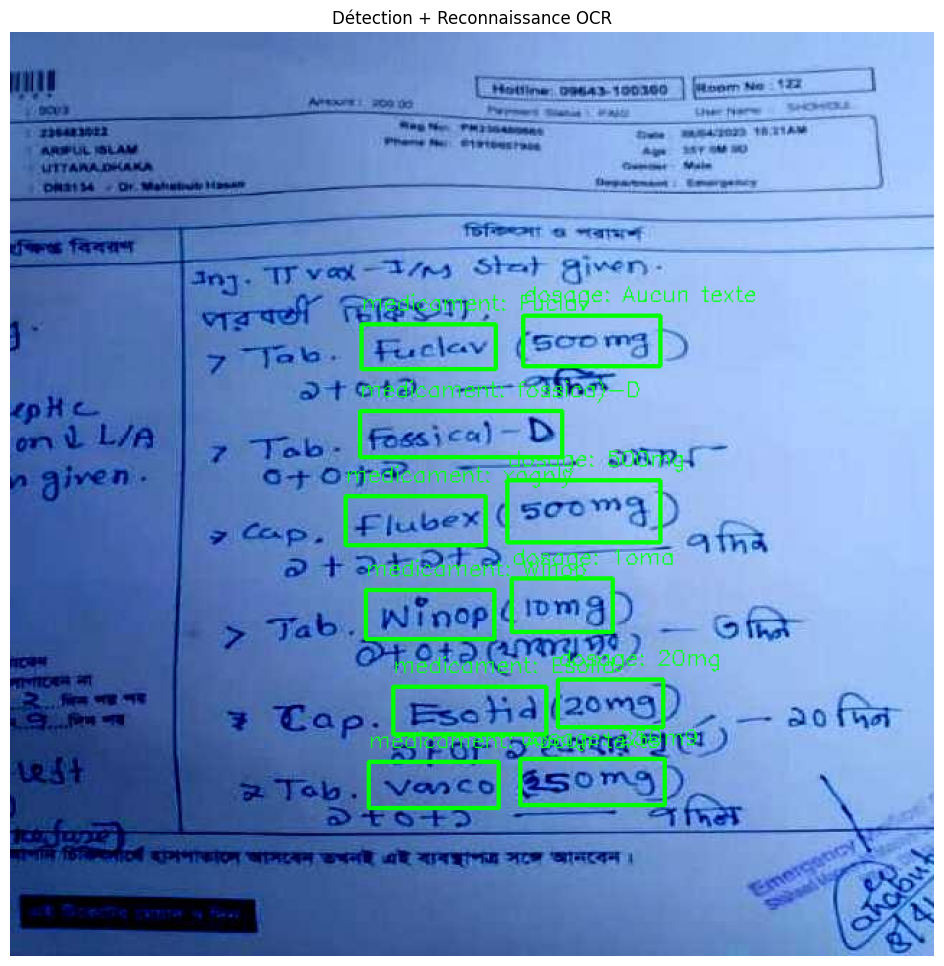

In [11]:
import cv2
import torch
from ultralytics import YOLO
from paddleocr import PaddleOCR
from huggingface_hub import hf_hub_download
import matplotlib.pyplot as plt

# Télécharger le modèle depuis Hugging Face
model_path = hf_hub_download(repo_id="toumix/yolo-medicament-dosage", filename="yolov8_best.pt")

# Charger le modèle YOLOv8
model = YOLO(model_path)

# Charger PaddleOCR (en français, avec rotation des textes)
ocr = PaddleOCR(use_angle_cls=True, lang='fr')

# Charger l’image d’entrée
image_path = "/content/eya_-2bh-6/test/images/174_jpg.rf.98f0da658267d54718ab8b6bd5d522d3.jpg"
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
annotated_image = image.copy()

# Faire l'inférence avec YOLO
results = model(image_path)[0]

for box in results.boxes:
    cls_id = int(box.cls[0])
    label = model.names[cls_id]
    conf = float(box.conf[0])

    x1, y1, x2, y2 = map(int, box.xyxy[0])
    cropped = image[y1:y2, x1:x2]

    if cropped.size == 0:
        print(f"[⚠️] Zone vide ignorée pour {label}")
        continue

    result_ocr = ocr.ocr(cropped, cls=True)

    if result_ocr and result_ocr[0]:
        text = result_ocr[0][0][1][0]
        print(f"[{label.upper()}] : {text}")
    else:
        text = "Aucun texte"
        print(f"[{label.upper()}] : Aucun texte reconnu")

    # Annoter l'image
    cv2.rectangle(annotated_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(annotated_image, f"{label}: {text}", (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (36, 255, 12), 1)

# Affichage avec matplotlib
plt.figure(figsize=(12, 12))
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Détection + Reconnaissance OCR")
plt.show()

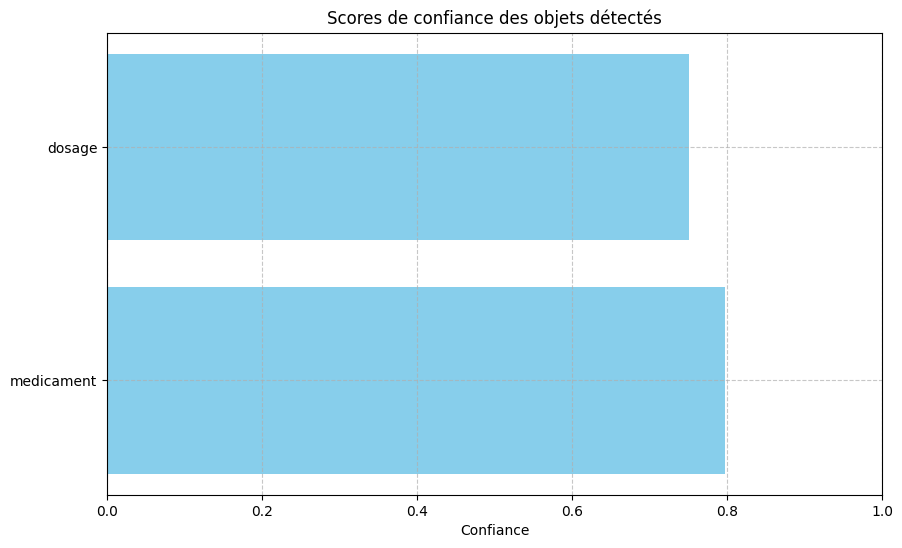

In [12]:
import numpy as np

labels = []
confidences = []

for box in results.boxes:
    cls_id = int(box.cls[0])
    label = model.names[cls_id]
    conf = float(box.conf[0])
    labels.append(label)
    confidences.append(conf)

# Affichage des scores
plt.figure(figsize=(10, 6))
plt.barh(labels, confidences, color='skyblue')
plt.xlabel('Confiance')
plt.title('Scores de confiance des objets détectés')
plt.xlim(0, 1)  # car la confiance est entre 0 et 1
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


  ## Détecte les régions d'intérêt dans une image   with yolo8L


📸 Traitement de l'image 1 : 0706-8979887-20230705_page_2_jpg.rf.92bfddb7a3a85dd7eb990afcf7fea275.jpg

0: 640x640 1 medicament, 62.6ms
Speed: 2.6ms preprocess, 62.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)
Détections trouvées : 1


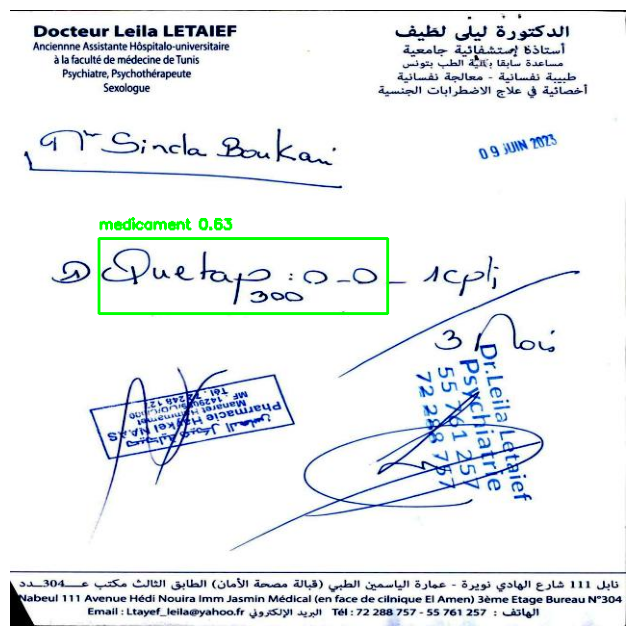


📸 Traitement de l'image 2 : 0709-9-550315-20230705_page_2_jpg.rf.a31c45cb09c027ed41be5361d91691ae.jpg

0: 640x640 1 dosage, 1 medicament, 62.7ms
Speed: 2.7ms preprocess, 62.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
Détections trouvées : 2


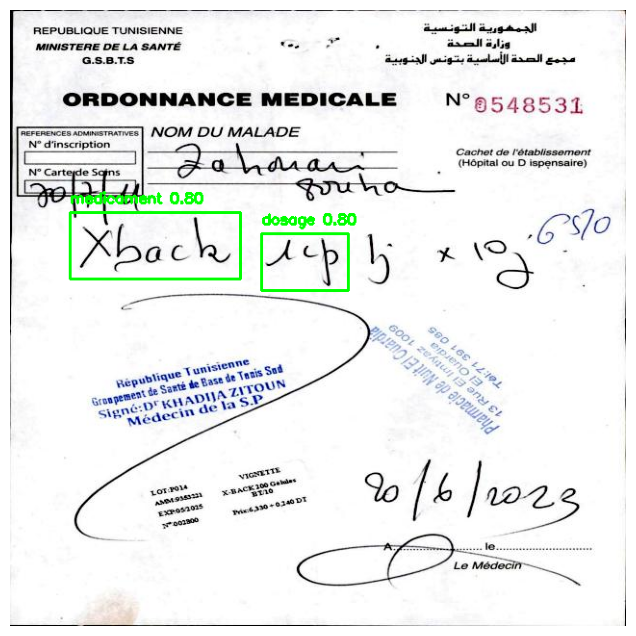


📸 Traitement de l'image 3 : 0711-8483891-20230705_page_2_jpg.rf.59afe3647fe77eed8edee0c4083077a7.jpg

0: 640x640 2 medicaments, 65.0ms
Speed: 2.5ms preprocess, 65.0ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)
Détections trouvées : 2


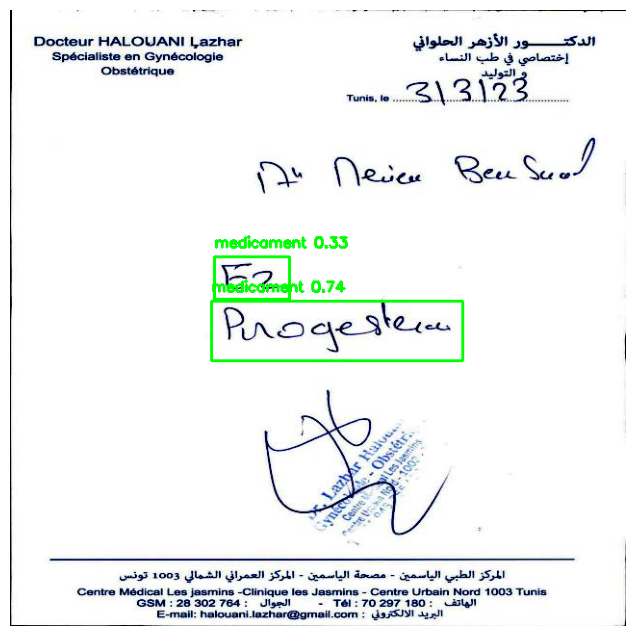


📸 Traitement de l'image 4 : 0717-9245943-20230705_page_2_jpg.rf.025bf8e3c65b8d0291cdfb208cd9711f.jpg

0: 640x640 1 medicament, 62.8ms
Speed: 2.7ms preprocess, 62.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)
Détections trouvées : 1


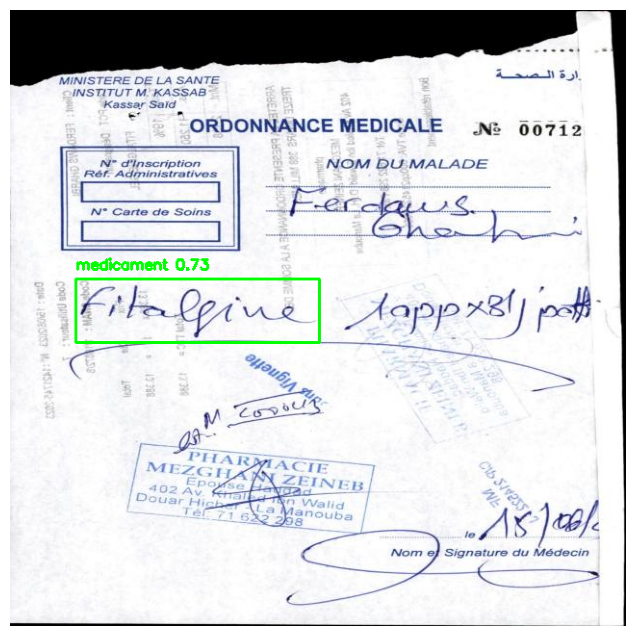


📸 Traitement de l'image 5 : 0721-9550371-20230705_page_2_jpg.rf.9c1e8c1fe67859f6a04bd5bf9e823f38.jpg

0: 640x640 2 medicaments, 62.8ms
Speed: 3.3ms preprocess, 62.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
Détections trouvées : 2


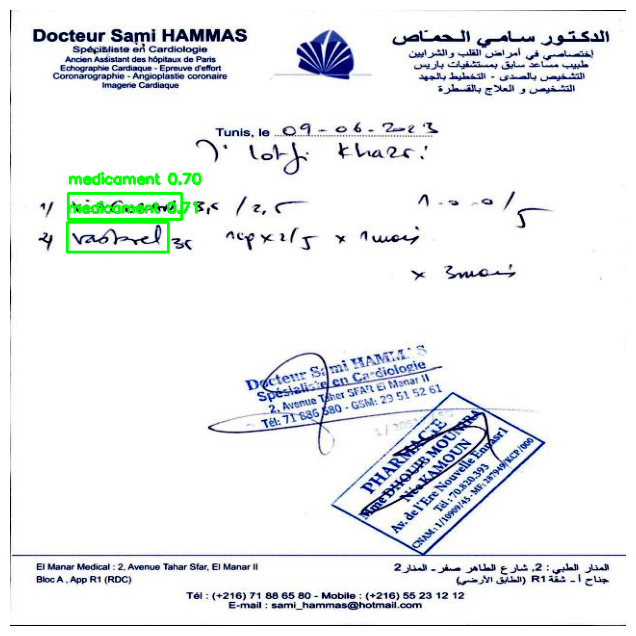

In [13]:
import cv2
import logging
import os
from ultralytics import YOLO
import matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download

# Télécharger le modèle YOLO depuis Hugging Face
YOLO_MODEL_PATH = hf_hub_download(repo_id="toumix/yolo-medicament-dosage", filename="yolov8_best.pt")

def visualize_detections(image, boxes, classes, confidences, class_names):
    """Visualise les résultats de la détection"""
    plt.figure(figsize=(12, 8))
    for box, cls, conf in zip(boxes, classes, confidences):
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        label = f"{class_names[int(cls)]} {conf:.2f}"
        cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

def detect_regions(image_path, model, conf=0.3):
    """Détecte les régions dans une image donnée à l'aide du modèle YOLO."""
    try:
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Impossible de charger l'image depuis {image_path}")

        results = model.predict(source=image, conf=conf, save=False)

        boxes = results[0].boxes.xyxy.cpu().numpy()
        classes = results[0].boxes.cls.cpu().numpy()
        confidences = results[0].boxes.conf.cpu().numpy()

        return image, boxes, classes, confidences

    except Exception as e:
        logging.error(f"Erreur de détection : {e}")
        return None, [], [], []

# Charger le modèle YOLO
try:
    model = YOLO(YOLO_MODEL_PATH)
except FileNotFoundError:
    print(f"Modèle YOLO introuvable à : {YOLO_MODEL_PATH}")
    exit()

# Dictionnaire des classes
class_names = {0: 'dosage', 1: 'medicament'}

# Dossier des images
dataset_dir = "/content/drive/MyDrive/pi_project_3/datasets/test/images"

# Lister les images et prendre les 5 premières
image_files = [os.path.join(dataset_dir, f) for f in os.listdir(dataset_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
image_files.sort()  # Tri par nom
first_five_images = image_files[:5]

if not first_five_images:
    print("Aucune image trouvée dans le dossier.")
    exit()

# Boucle sur les 5 premières images
for idx, image_path in enumerate(first_five_images, 1):
    print(f"\n📸 Traitement de l'image {idx} : {os.path.basename(image_path)}")
    img, boxes, classes, confs = detect_regions(image_path, model)

    if img is not None:
        print(f"Détections trouvées : {len(boxes)}")
        visualize_detections(img, boxes, classes, confs, class_names)
    else:
        print("Échec de la détection pour cette image.")


[2025/04/13 22:36:13] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/latin/latin_PP-OCRv3_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_

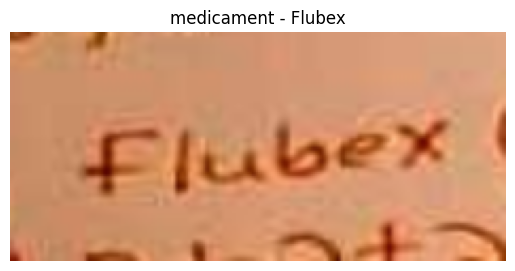

[2025/04/13 22:36:15] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.01537179946899414
[2025/04/13 22:36:15] ppocr DEBUG: rec_res num  : 1, elapsed : 0.0263059139251709
MEDICAMENT : Winop


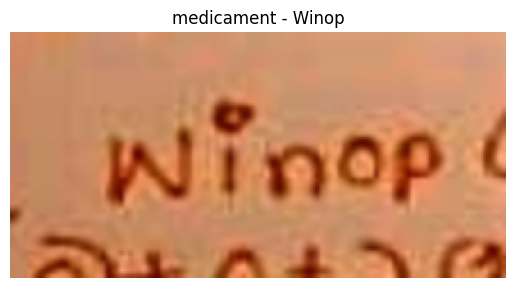

[2025/04/13 22:36:15] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.017122745513916016
[2025/04/13 22:36:15] ppocr DEBUG: rec_res num  : 2, elapsed : 0.06765532493591309
MEDICAMENT : Puclav


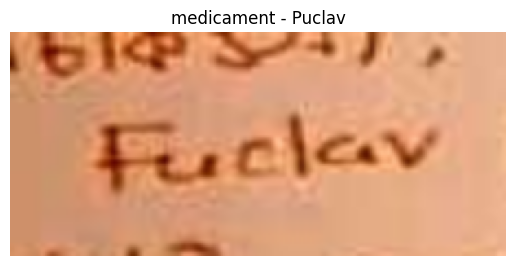

[2025/04/13 22:36:16] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.03941988945007324
[2025/04/13 22:36:16] ppocr DEBUG: rec_res num  : 0, elapsed : 9.5367431640625e-07
DOSAGE : 


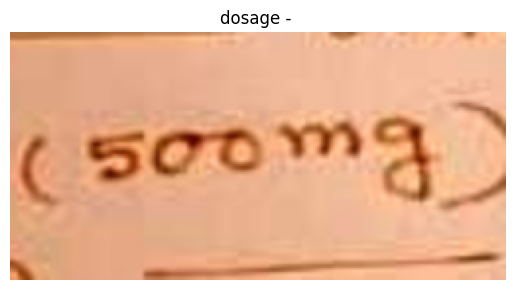

[2025/04/13 22:36:16] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.019074440002441406
[2025/04/13 22:36:16] ppocr DEBUG: rec_res num  : 1, elapsed : 0.04211878776550293
DOSAGE : 50omg


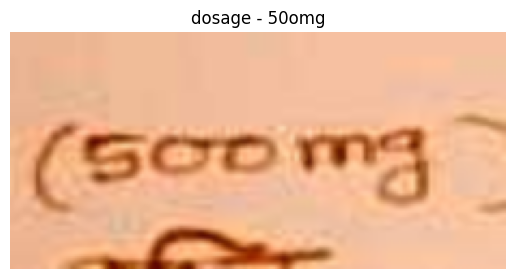

[2025/04/13 22:36:16] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.040215492248535156
[2025/04/13 22:36:16] ppocr DEBUG: rec_res num  : 1, elapsed : 0.028437376022338867
DOSAGE : 250M


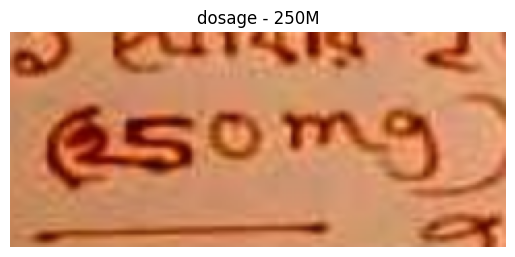

[2025/04/13 22:36:16] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.04237055778503418
[2025/04/13 22:36:16] ppocr DEBUG: rec_res num  : 1, elapsed : 0.028341293334960938
DOSAGE : 20m9


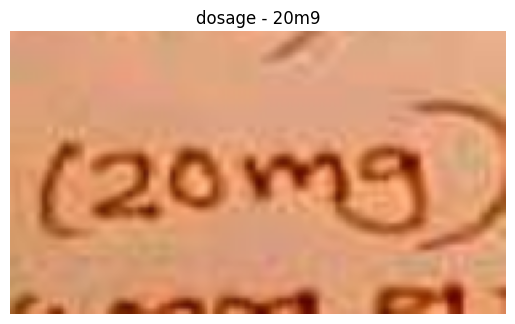

[2025/04/13 22:36:16] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.045105695724487305
[2025/04/13 22:36:16] ppocr DEBUG: rec_res num  : 1, elapsed : 0.032842397689819336
DOSAGE : C1omg


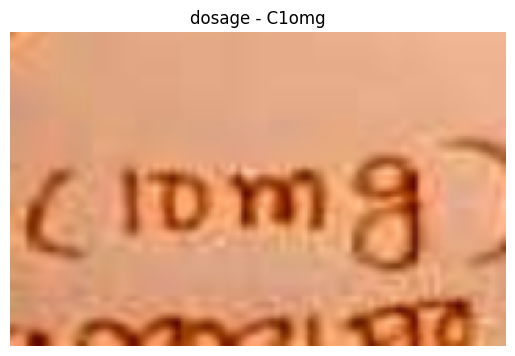

[2025/04/13 22:36:17] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.017974138259887695
[2025/04/13 22:36:17] ppocr DEBUG: rec_res num  : 1, elapsed : 0.03129267692565918
MEDICAMENT : Esoid


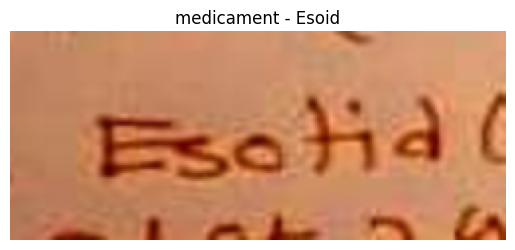

[2025/04/13 22:36:17] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.05043768882751465
[2025/04/13 22:36:17] ppocr DEBUG: rec_res num  : 1, elapsed : 0.05606198310852051
MEDICAMENT : fossica-D


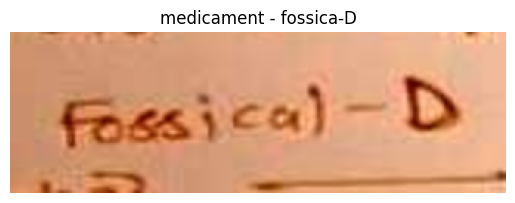

[2025/04/13 22:36:17] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.019234418869018555
[2025/04/13 22:36:17] ppocr DEBUG: rec_res num  : 1, elapsed : 0.035857200622558594
MEDICAMENT : Vaco


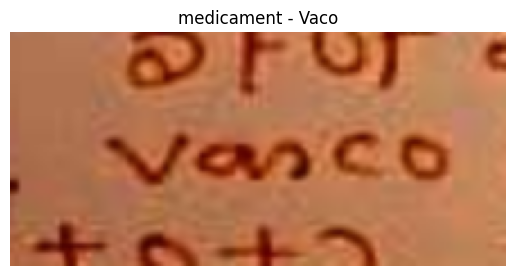

✅ Résultats sauvegardés dans : /content/drive/MyDrive/pi_project_3/datasets/rois/ocr_results_cleaned10.csv


In [14]:
from paddleocr import PaddleOCR
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO
from huggingface_hub import hf_hub_download
def extract_rois_and_ocr(image_path, model_path, output_dir, categories=['dosage', 'medicament']):
    # Charger le modèle YOLO
    try:
        model = YOLO(model_path,)
    except Exception as e:
        print(f"Erreur lors du chargement du modèle YOLO : {e}")
        return []

    # Initialiser PaddleOCR
    ocr = PaddleOCR(use_angle_cls=False, lang="fr")  # angle_cls désactivé = plus rapide + plus stable

    # Créer le dossier de sortie s'il n'existe pas
    os.makedirs(output_dir, exist_ok=True)

    # Prédire avec YOLO
    try:
        results = model.predict(image_path)
    except Exception as e:
        print(f"Erreur lors de la prédiction avec YOLO : {e}")
        return []

    ocr_results = []

    for i, r in enumerate(results):
        img = cv2.cvtColor(r.orig_img, cv2.COLOR_RGB2BGR)
        boxes = r.boxes.xyxy.cpu().numpy()
        confidences = r.boxes.conf.cpu().numpy()
        classes = r.boxes.cls.cpu().numpy()

        for j, (box, conf, cls) in enumerate(zip(boxes, confidences, classes)):
            x1, y1, x2, y2 = map(int, box)
            category = categories[int(cls)]

            # 🟡 Ajout de marge autour du ROI
            margin = 10
            x1 = max(x1 - margin, 0)
            y1 = max(y1 - margin, 0)
            x2 = min(x2 + margin, img.shape[1])
            y2 = min(y2 + margin, img.shape[0])
            roi = img[y1:y2, x1:x2]

            # 🔵 Redimensionner le ROI pour améliorer la reconnaissance
            if roi.shape[0] > 0 and roi.shape[1] > 0:  # Vérifier que le ROI n'est pas vide
                roi = cv2.resize(roi, (roi.shape[1]*2, roi.shape[0]*2), interpolation=cv2.INTER_LINEAR)
            else:
                print(f"ROI vide pour {category} à l'index {j}, ignoré.")
                continue

            # Sauvegarder le ROI
            roi_path = os.path.join(output_dir, f"roi_{i}_{j}.png")
            cv2.imwrite(roi_path, roi)

            # 🟣 Appliquer OCR
            try:
                result = ocr.ocr(roi_path, cls=False)
                pred_text = ""
                if result and result[0]:
                    pred_text = " ".join([line[1][0] for line in result[0] if line[1][0]])
            except Exception as e:
                print(f"Erreur lors de l'OCR pour {roi_path} : {e}")
                pred_text = ""

            # 🟠 Ajout au tableau de résultats
            ocr_results.append({
                'image_path': image_path,
                'roi_path': roi_path,
                'bbox': [x1, y1, x2, y2],
                'category': category,
                'confidence': float(conf),
                'predicted_text': pred_text
            })

            # 🔎 (Optionnel) Affichage pour debug
            print(f"{category.upper()} : {pred_text}")
            plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
            plt.title(f"{category} - {pred_text}")
            plt.axis("off")
            plt.show()

    # 🔴 Sauvegarde CSV
    df = pd.DataFrame(ocr_results)
    csv_path = os.path.join(output_dir, "ocr_results_cleaned10.csv")
    df.to_csv(csv_path, index=False)
    print(f"✅ Résultats sauvegardés dans : {csv_path}")
    return ocr_results

# Définir les chemins adaptés à votre projet
dataset_dir = "/content/drive/MyDrive/pi_project_3/datasets"
image_path = os.path.join(dataset_dir, 'test/images/174_jpg.rf.98f0da658267d54718ab8b6bd5d522d3.jpg')


model_path = hf_hub_download(repo_id="toumix/yolo-medicament-dosage", filename="yolov8_best.pt")

output_dir = os.path.join(dataset_dir, "rois")

# Vérifier que les fichiers existent
if not os.path.exists(image_path):
    print(f"Image introuvable à : {image_path}")
else:
    if not os.path.exists(model_path):
        print(f"Modèle introuvable à : {model_path}")
    else:
        # Exécuter la fonction
        initial_results = extract_rois_and_ocr(image_path, model_path, output_dir)




# Code pour correction manuelle (optionnel) :

Nombre d'images de test trouvées : 233

Traitement de l'image : 5249-9402990-20230914_page_2_jpg.rf.668abe9fb499c70e7a8d4f4705aac1f7.jpg
[2025/04/13 22:36:17] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_d

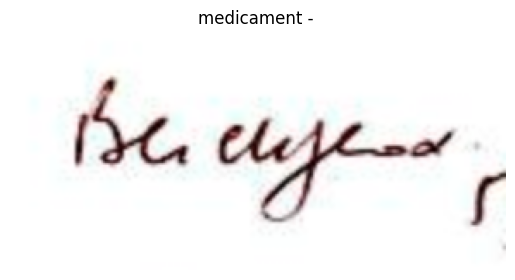

[2025/04/13 22:36:19] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.021286487579345703
[2025/04/13 22:36:19] ppocr DEBUG: rec_res num  : 2, elapsed : 0.07290911674499512
MEDICAMENT : 


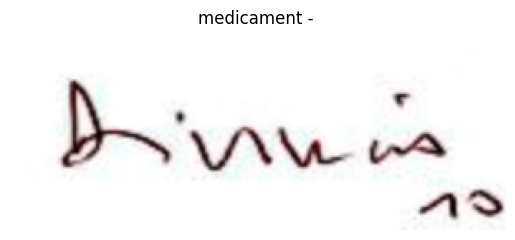

[2025/04/13 22:36:19] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.05216073989868164
[2025/04/13 22:36:19] ppocr DEBUG: rec_res num  : 2, elapsed : 0.046892404556274414
MEDICAMENT : VeLout


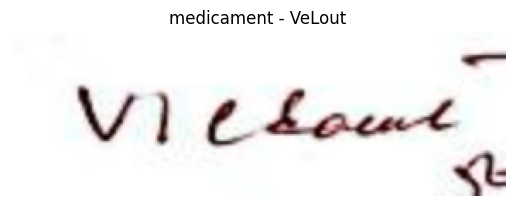

[2025/04/13 22:36:19] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.04231905937194824
[2025/04/13 22:36:19] ppocr DEBUG: rec_res num  : 0, elapsed : 1.2636184692382812e-05
DOSAGE : 


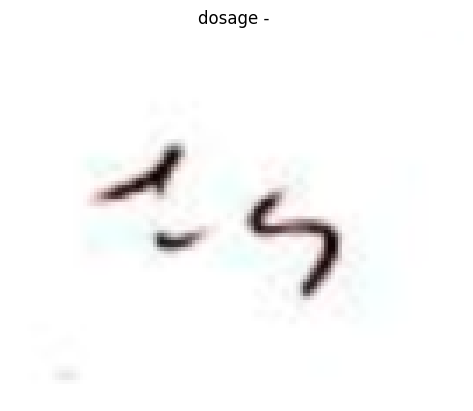

✅ Résultats sauvegardés dans : /content/drive/MyDrive/pi_project_3/datasets/rois/ocr_results_5249-9402990-20230914_page_2_jpg.csv

Traitement de l'image : Beauty_prescription_44_jpg.rf.4d15320fe4c8682e46a1d00562c12f15.jpg
[2025/04/13 22:36:19] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16

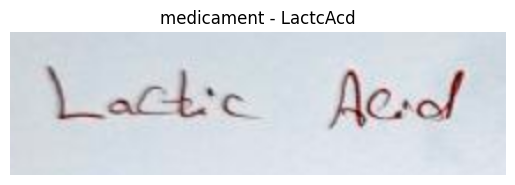

[2025/04/13 22:36:21] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.06515812873840332
[2025/04/13 22:36:21] ppocr DEBUG: rec_res num  : 1, elapsed : 0.060735464096069336
MEDICAMENT : Vtamin C Serun


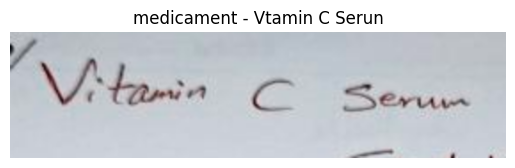

[2025/04/13 22:36:21] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.02600860595703125
[2025/04/13 22:36:21] ppocr DEBUG: rec_res num  : 1, elapsed : 0.032283782958984375
MEDICAMENT : Collagen


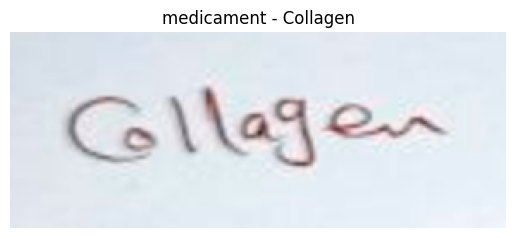

✅ Résultats sauvegardés dans : /content/drive/MyDrive/pi_project_3/datasets/rois/ocr_results_Beauty_prescription_44_jpg.csv

Traitement de l'image : 306367570_611939117308246_5947370835283610669_n_jpg.rf.492e0b6c2b4fd69c617f09863247e8cf.jpg
[2025/04/13 22:36:21] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_sca

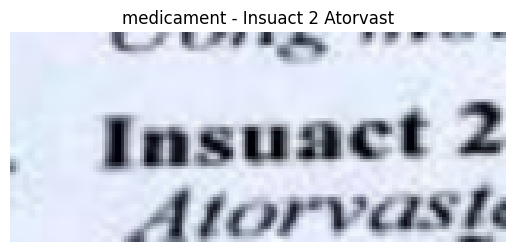

[2025/04/13 22:36:23] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.04427742958068848
[2025/04/13 22:36:23] ppocr DEBUG: rec_res num  : 2, elapsed : 0.050652503967285156
DOSAGE : 020mg itin


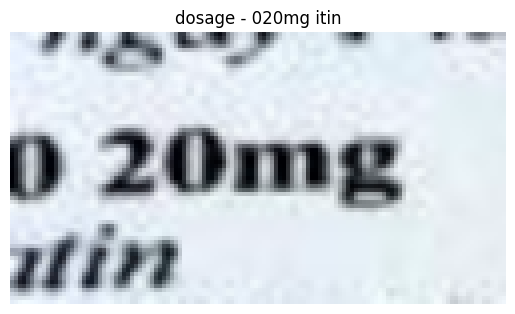

[2025/04/13 22:36:23] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.012034416198730469
[2025/04/13 22:36:23] ppocr DEBUG: rec_res num  : 1, elapsed : 0.034195661544799805
DOSAGE : 0300mg


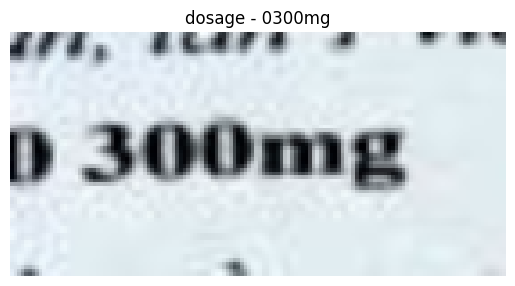

[2025/04/13 22:36:23] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.013379096984863281
[2025/04/13 22:36:23] ppocr DEBUG: rec_res num  : 2, elapsed : 0.047756195068359375
DOSAGE : g850mg


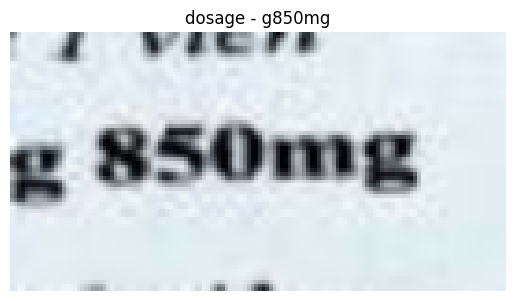

[2025/04/13 22:36:23] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.011798858642578125
[2025/04/13 22:36:23] ppocr DEBUG: rec_res num  : 1, elapsed : 0.0314478874206543
DOSAGE : 850mg8


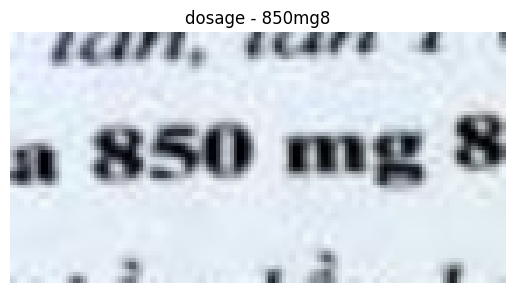

[2025/04/13 22:36:23] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.05693554878234863
[2025/04/13 22:36:24] ppocr DEBUG: rec_res num  : 3, elapsed : 0.14492368698120117
MEDICAMENT : Metformin Stclla 8 Mettormin


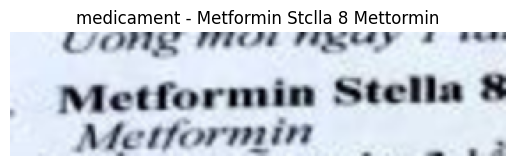

[2025/04/13 22:36:24] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.015306711196899414
[2025/04/13 22:36:24] ppocr DEBUG: rec_res num  : 3, elapsed : 0.09749698638916016
MEDICAMENT : Ebitac1 Enalap


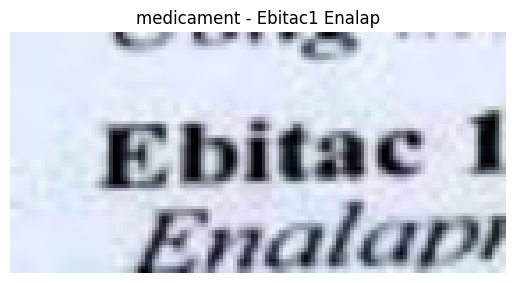

[2025/04/13 22:36:24] ppocr DEBUG: dt_boxes num : 0, elapsed : 0.016273975372314453
[2025/04/13 22:36:24] ppocr DEBUG: rec_res num  : 0, elapsed : 1.1920928955078125e-06
DOSAGE : 


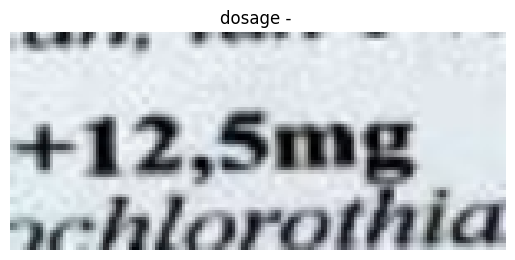

[2025/04/13 22:36:24] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.014907360076904297
[2025/04/13 22:36:24] ppocr DEBUG: rec_res num  : 1, elapsed : 0.031026363372802734
DOSAGE : R.60mg


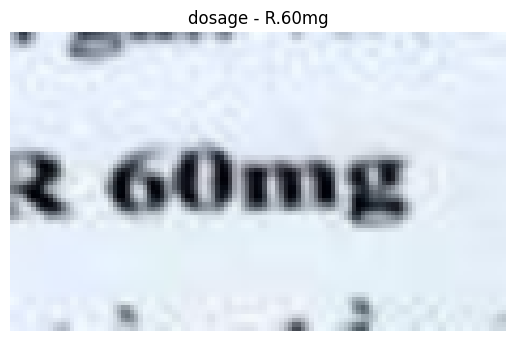

[2025/04/13 22:36:24] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.013786554336547852
[2025/04/13 22:36:24] ppocr DEBUG: rec_res num  : 1, elapsed : 0.030611038208007812
DOSAGE : 


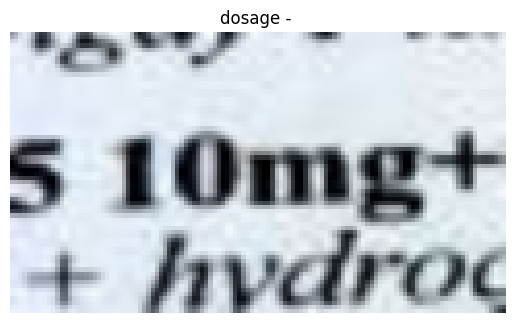

[2025/04/13 22:36:24] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.015192031860351562
[2025/04/13 22:36:24] ppocr DEBUG: rec_res num  : 2, elapsed : 0.1090550422668457
MEDICAMENT : Staclazide 60 MR 6 Gliclarid


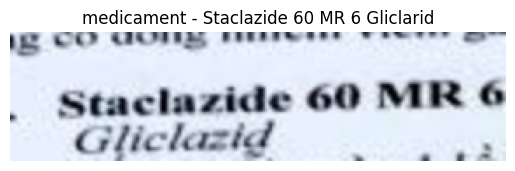

[2025/04/13 22:36:24] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.05568051338195801
[2025/04/13 22:36:25] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1316392421722412
MEDICAMENT : Sa Vi Tenofovir 3 Tenotovir(TDF)


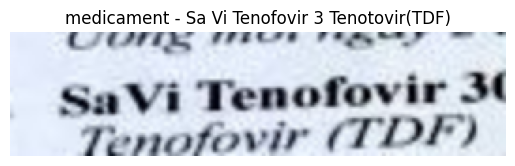

[2025/04/13 22:36:25] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.07098388671875
[2025/04/13 22:36:25] ppocr DEBUG: rec_res num  : 2, elapsed : 0.16314053535461426
MEDICAMENT : Staclazide 60 M Gliclazid


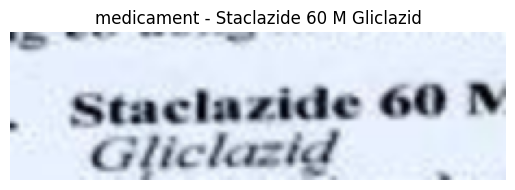

✅ Résultats sauvegardés dans : /content/drive/MyDrive/pi_project_3/datasets/rois/ocr_results_306367570_611939117308246_5947370835283610669_n_jpg.csv

Traitement de l'image : Neurology_prescription_44_jpg.rf.6d16efe1cb554e191d2cd97cafc9539d.jpg
[2025/04/13 22:36:25] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_

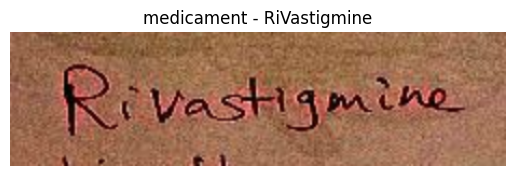

✅ Résultats sauvegardés dans : /content/drive/MyDrive/pi_project_3/datasets/rois/ocr_results_Neurology_prescription_44_jpg.csv

Traitement de l'image : Neurology_prescription_110_jpg.rf.434802bc54ab131a539f4fb9f3abab93.jpg
[2025/04/13 22:36:28] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 1

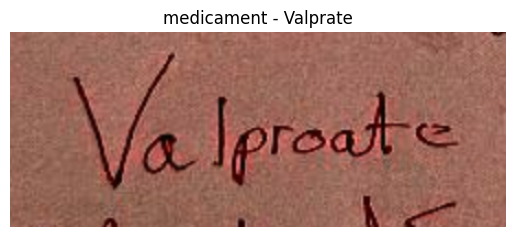

[2025/04/13 22:36:30] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08682703971862793
[2025/04/13 22:36:30] ppocr DEBUG: rec_res num  : 1, elapsed : 0.04003715515136719
MEDICAMENT : SabaPertin


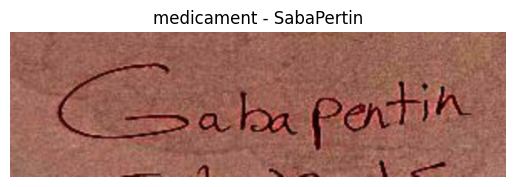

[2025/04/13 22:36:30] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08923554420471191
[2025/04/13 22:36:30] ppocr DEBUG: rec_res num  : 1, elapsed : 0.03917098045349121
MEDICAMENT : Mantadine


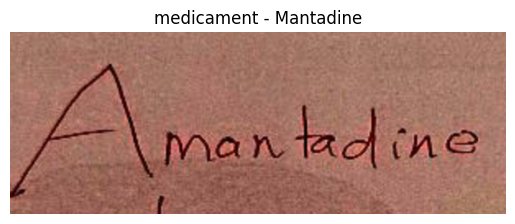

✅ Résultats sauvegardés dans : /content/drive/MyDrive/pi_project_3/datasets/rois/ocr_results_Neurology_prescription_110_jpg.csv

Traitement de l'image : 4430-9271793-20230901-5748_page_2_jpg.rf.1039ce94412331db90c35f16f9a01c51.jpg
[2025/04/13 22:36:30] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scal

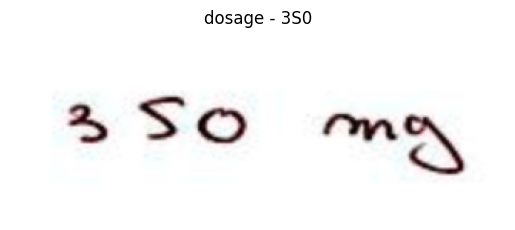

[2025/04/13 22:36:32] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.06641626358032227
[2025/04/13 22:36:32] ppocr DEBUG: rec_res num  : 1, elapsed : 0.07201266288757324
MEDICAMENT : ommmipage


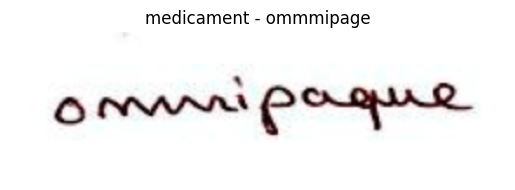

✅ Résultats sauvegardés dans : /content/drive/MyDrive/pi_project_3/datasets/rois/ocr_results_4430-9271793-20230901-5748_page_2_jpg.csv

Traitement de l'image : 0750-9550274-20230705_page_2_jpg.rf.c3813d810ab939ffe4621dd59a706aaf.jpg
[2025/04/13 22:36:32] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, sc

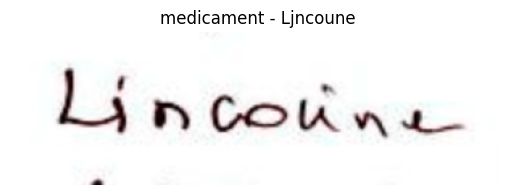

[2025/04/13 22:36:34] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.09174513816833496
[2025/04/13 22:36:34] ppocr DEBUG: rec_res num  : 2, elapsed : 0.09319639205932617
MEDICAMENT : A&ulre


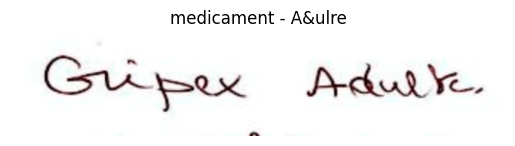

[2025/04/13 22:36:34] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.0620884895324707
[2025/04/13 22:36:34] ppocr DEBUG: rec_res num  : 1, elapsed : 0.03933906555175781
MEDICAMENT : pedour


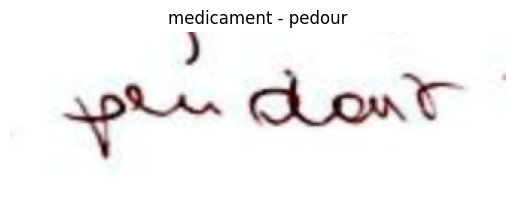

[2025/04/13 22:36:34] ppocr DEBUG: dt_boxes num : 2, elapsed : 0.0627443790435791
[2025/04/13 22:36:34] ppocr DEBUG: rec_res num  : 2, elapsed : 0.05750322341918945
DOSAGE : R


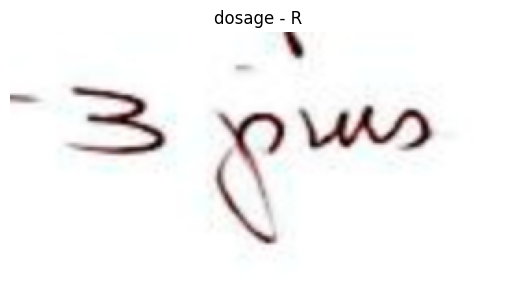

[2025/04/13 22:36:34] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.06673097610473633
[2025/04/13 22:36:35] ppocr DEBUG: rec_res num  : 3, elapsed : 0.10755491256713867
MEDICAMENT : arms en


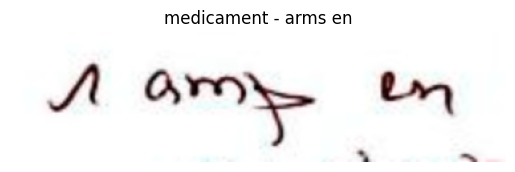

[2025/04/13 22:36:35] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.03863811492919922
[2025/04/13 22:36:35] ppocr DEBUG: rec_res num  : 1, elapsed : 0.039635658264160156
MEDICAMENT : pende


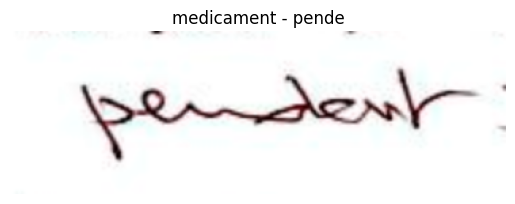

✅ Résultats sauvegardés dans : /content/drive/MyDrive/pi_project_3/datasets/rois/ocr_results_0750-9550274-20230705_page_2_jpg.csv

Traitement de l'image : 6833-9127798-20230922_page_2_jpg.rf.8c911cc9a62edb63e07e4f0325b0b9ec.jpg
[2025/04/13 22:36:35] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=

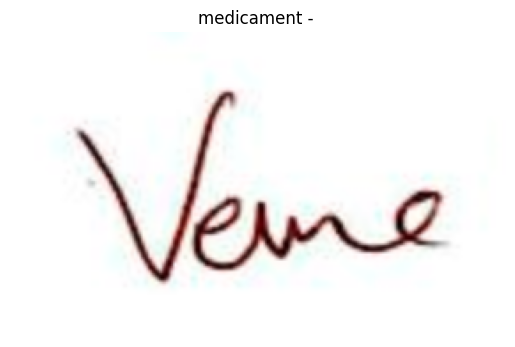

[2025/04/13 22:36:37] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08892488479614258
[2025/04/13 22:36:37] ppocr DEBUG: rec_res num  : 1, elapsed : 0.0485532283782959
MEDICAMENT : Pengees


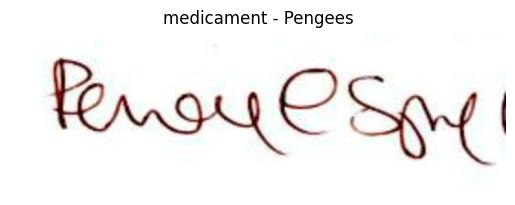

[2025/04/13 22:36:37] ppocr DEBUG: dt_boxes num : 1, elapsed : 0.08658814430236816
[2025/04/13 22:36:37] ppocr DEBUG: rec_res num  : 1, elapsed : 0.04213857650756836
DOSAGE : K oP


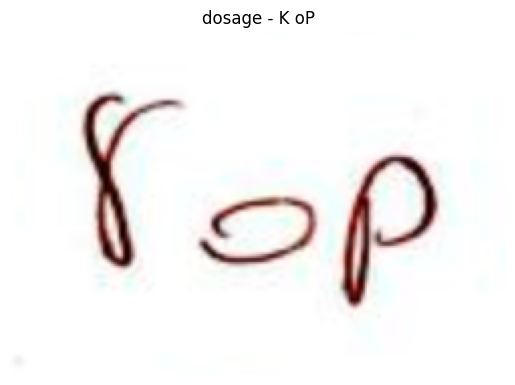

✅ Résultats sauvegardés dans : /content/drive/MyDrive/pi_project_3/datasets/rois/ocr_results_6833-9127798-20230922_page_2_jpg.csv

Traitement de l'image : 4430-9271793-20230901-5748_page_3_jpg.rf.12e1aef694d9aa3af8a5c4c8bb22d63f.jpg
[2025/04/13 22:36:37] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, use_gcu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, sc

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-7a2b2b72cac3>", line 135, in <cell line: 0>
    ocr_results, empty_pred_texts = extract_rois_and_ocr(image_path, model_path, output_dir)
                                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-15-7a2b2b72cac3>", line 25, in extract_rois_and_ocr
    results = model.predict(image_path)
              ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/engine/model.py", line 543, in predict
    self.predictor.setup_model(model=self.model, verbose=is_cli)
  File "/usr/local/lib/python3.11/dist-packages/ultralytics/engine/predictor.py", line 380, in setup_model
    self.model = AutoBackend(
                 ^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/_co

TypeError: object of type 'NoneType' has no len()

In [15]:





from paddleocr import PaddleOCR
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO
from huggingface_hub import hf_hub_download

def extract_rois_and_ocr(image_path, model_path, output_dir, categories=['dosage', 'medicament']):
    # Charger le modèle YOLO
    try:
        model = YOLO(model_path)
    except Exception as e:
        print(f"Erreur lors du chargement du modèle YOLO : {e}")
        return []

    # Initialiser PaddleOCR
    ocr = PaddleOCR(use_angle_cls=False, lang="fr")  # angle_cls désactivé = plus rapide + plus stable

    # Créer le dossier de sortie s'il n'existe pas
    os.makedirs(output_dir, exist_ok=True)

    # Prédire avec YOLO
    try:
        results = model.predict(image_path)
    except Exception as e:
        print(f"Erreur lors de la prédiction avec YOLO : {e}")
        return []

    ocr_results = []
    empty_pred_texts = []  # Liste pour stocker les cas où pred_text est vide

    for i, r in enumerate(results):
        img = cv2.cvtColor(r.orig_img, cv2.COLOR_RGB2BGR)
        boxes = r.boxes.xyxy.cpu().numpy()
        confidences = r.boxes.conf.cpu().numpy()
        classes = r.boxes.cls.cpu().numpy()

        for j, (box, conf, cls) in enumerate(zip(boxes, confidences, classes)):
            x1, y1, x2, y2 = map(int, box)
            category = categories[int(cls)]

            # 🟡 Ajout de marge autour du ROI
            margin = 10
            x1 = max(x1 - margin, 0)
            y1 = max(y1 - margin, 0)
            x2 = min(x2 + margin, img.shape[1])
            y2 = min(y2 + margin, img.shape[0])
            roi = img[y1:y2, x1:x2]

            # 🔵 Redimensionner le ROI pour améliorer la reconnaissance
            if roi.shape[0] > 0 and roi.shape[1] > 0:  # Vérifier que le ROI n'est pas vide
                roi = cv2.resize(roi, (roi.shape[1]*2, roi.shape[0]*2), interpolation=cv2.INTER_LINEAR)
            else:
                print(f"ROI vide pour {category} à l'index {j}, ignoré.")
                continue

            # Sauvegarder le ROI
            roi_path = os.path.join(output_dir, f"roi_{i}_{j}.png")
            cv2.imwrite(roi_path, roi)

            # 🟣 Appliquer OCR
            try:
                result = ocr.ocr(roi_path, cls=False)
                pred_text = ""
                if result and result[0]:
                    pred_text = " ".join([line[1][0] for line in result[0] if line[1][0]])
            except Exception as e:
                print(f"Erreur lors de l'OCR pour {roi_path} : {e}")
                pred_text = ""

            # 🟠 Ajout au tableau de résultats
            result_entry = {
                'image_path': image_path,
                'roi_path': roi_path,
                'bbox': [x1, y1, x2, y2],
                'category': category,
                'confidence': float(conf),
                'predicted_text': pred_text if pred_text else "Non détecté"
            }
            ocr_results.append(result_entry)

            # 🔎 Vérifier si pred_text est vide
            if not pred_text or pred_text == "Non détecté":
                empty_pred_texts.append({
                    'image_path': image_path,
                    'roi_path': roi_path,
                    'category': category,
                    'confidence': float(conf)
                })

            # 🔎 (Optionnel) Affichage pour debug
            print(f"{category.upper()} : {pred_text}")
            plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
            plt.title(f"{category} - {pred_text}")
            plt.axis("off")
            plt.show()

    # 🔴 Sauvegarde CSV pour cette image
    df = pd.DataFrame(ocr_results)
    csv_path = os.path.join(output_dir, f"ocr_results_{os.path.basename(image_path).split('.')[0]}.csv")
    df.to_csv(csv_path, index=False)
    print(f"✅ Résultats sauvegardés dans : {csv_path}")

    return ocr_results, empty_pred_texts

# Définir les chemins adaptés à votre projet
dataset_dir = "/content/drive/MyDrive/pi_project_3/datasets"
test_images_dir = os.path.join(dataset_dir, "test/images")
model_path = hf_hub_download(repo_id="toumix/yolo-medicament-dosage", filename="yolov8_best.pt")
output_dir = os.path.join(dataset_dir, "rois")

# Vérifier que le modèle existe
if not os.path.exists(model_path):
    print(f"Modèle introuvable à : {model_path}")
    exit()

# Lister toutes les images dans le dossier test/images
try:
    test_images = [f for f in os.listdir(test_images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    print(f"Nombre d'images de test trouvées : {len(test_images)}")
except Exception as e:
    print(f"Erreur lors de la lecture du dossier {test_images_dir} : {e}")
    exit()

# Liste pour stocker toutes les images avec des pred_text vides
all_empty_pred_texts = []

# Parcourir chaque image
for image_name in test_images:
    image_path = os.path.join(test_images_dir, image_name)
    print(f"\nTraitement de l'image : {image_name}")

    # Exécuter la fonction pour cette image
    ocr_results, empty_pred_texts = extract_rois_and_ocr(image_path, model_path, output_dir)

    # Ajouter les cas de pred_text vide à la liste globale
    if empty_pred_texts:
        all_empty_pred_texts.extend(empty_pred_texts)

# Afficher et sauvegarder la liste des images avec pred_text vide
if all_empty_pred_texts:
    print("\n=== Images avec pred_text vide ===")
    empty_df = pd.DataFrame(all_empty_pred_texts)
    for idx, row in empty_df.iterrows():
        print(f"Image: {os.path.basename(row['image_path'])}, Catégorie: {row['category']}, "
              f"Confidence: {row['confidence']:.2f}, ROI: {row['roi_path']}")

    # Sauvegarder dans un CSV pour correction manuelle
    empty_csv_path = os.path.join(output_dir, "images_with_empty_pred_text.csv")
    empty_df.to_csv(empty_csv_path, index=False)
    print(f"\n✅ Liste des images avec pred_text vide sauvegardée dans : {empty_csv_path}")
else:
    print("\nAucune image avec pred_text vide n'a été trouvée.")

# Sauvegarder les résultats corrigés